In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense

import os

from IPython.display import display

import sys
sys.path.append('custom_modules')

import Data_processing as dp
import Data_visualization as dv

In [26]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

In [ ]:
path_to_data2 = "Data\Обработанные данные"

In [27]:
# всякие константы для последующей работы

#///////////////////////////////// для взятия данных из файлов

path_to_data = 'ngp.csv' # путь к файлу, из которого берутся данные для обучения
target = 'price' # название взятой величины из файла

#///////////////////////////////// для создания слоев

CRT_hidden_layer_act_fun = 'relu'   # функция активация скрытых слоев и входного
CRT_output_layer_act_fun = 'sigmoid' # функция активация выходного слоя

CRT_dict = {4: CRT_hidden_layer_act_fun, 
            400: CRT_hidden_layer_act_fun,
            20: CRT_hidden_layer_act_fun,
            1: CRT_output_layer_act_fun} # size(layer) plus activation func

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.00005 # шаг сходимости back propogation
CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
CMP_loss_func = 'mean_squared_error'# функция потерь

#///////////////////////////////// для колбэков

    # для Early_stopping
ES_patience = 15 # кол-во эпох без улучшений
ES_min_delta = 0.0001 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'loss' # отслеживаемый параметр 
ES_save_best_weights = True # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'val_loss'  # отслеживаемый параметр 
RLPOP_factor = 0.1 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 10 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.0001 # порог изменения отслеживаемого значения
RLPOP_cooldown = 0 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 4 #13, 4 # размер bach при обучении/тестировании
FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 50 # количество эпох обучения
FIT_validation_split = 0.2 # процент валидационных данных, отсекаемых из тестовой выборки

In [28]:
# извлечь датасет из файла
def get_df(path, target_name):
    file = pd.read_csv(path)
    dframe = pd.DataFrame(list(reversed(file[target_name])))
    return dframe

In [29]:
# заполнить колонки и имена колонок для тестового датасета
def get_cols_and_names(df):
    input_t = 4
    output_t = 1
    
    cols = list()
    names = list()
    
    for i in range(input_t,0, -1):
        cols.append(df.shift(i))
        names.append(i)
    for i in range(0,output_t):
        cols.append(df.shift(-i))                    
        names.append(i+input_t+1)
    return cols,names

In [30]:
# разбиение данных на тестовые и тренировочные
def split(X,Y,factor):
    X_train=X[:factor]
    Y_train=Y[:factor]
    X_test=X[factor:]
    Y_test=Y[factor:]
    return X_train,Y_train,X_test,Y_test

In [31]:
# подготовить датасет из файла
def prepare_df(cols,names):
    n_df = pd.concat(cols, axis = 1)
    n_df.columns = names
    n_df.dropna(inplace = True)
    return n_df

In [32]:
#подготовить данные к разбиению на тестовые и тренировочные
def prep_data_4_1_time(cols, names, prepared_df):
    X = prepared_df[[4, 3, 2, 1]]
    Y = prepared_df[5]
    X = X / X.max()
    Y = np.asarray(Y)
    Y = Y / Y.max()
    
    factor = int(.80*X.shape[0])

    print("X", type(X), X.shape)
    print("Y", type(Y), Y.shape)
    display(X)
    display(Y)
    
    return split(X ,Y , factor)

In [33]:
# создание архитектуры нейронки
model = keras.Sequential()

for x in CRT_dict.items():
    model.add(Dense(x[0], activation = x[1]))
    
model.compile(loss = CMP_loss_func, optimizer = CMP_solver)

In [35]:
# Создание и настройка колбэков
callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

temp = keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights
            )
callback_list.append(temp)

temp = keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            )
callback_list.append(temp)

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [36]:
# подготовка данных

# извлечь датасет из файла
df = get_df(path_to_data, target)

# заполнить колонки и имена колонок для тестового датасета
cols, names = get_cols_and_names(df)

# создать тестовый/тренировочный датасет
prepared_df = prepare_df(cols,names)

# создать тестовые/тренировочные данные из тестового датасета
prepared_data = prep_data_4_1_time(cols, names, prepared_df)

X_train,Y_train,X_test,Y_test = prepared_data

X <class 'pandas.core.frame.DataFrame'> (1073, 4)
Y <class 'numpy.ndarray'> (1073,)


,4,3,2,1
4,0.261560,0.289165,0.205659,0.200828
5,0.289165,0.205659,0.200828,0.174603
6,0.205659,0.200828,0.174603,0.158730
7,0.200828,0.174603,0.158730,0.131815
8,0.174603,0.158730,0.131815,0.125604
...,...,...,...,...
1077,0.193237,0.196687,0.203589,0.204969
1078,0.196687,0.203589,0.204969,0.202208
1079,0.203589,0.204969,0.202208,0.200828
1080,0.204969,0.202208,0.200828,0.204279


array([0.17460317, 0.15873016, 0.13181504, ..., 0.20427881, 0.21325052,
       0.20427881])

In [12]:
# тренировка модели
'''history = model.fit(X_train, 
                    Y_train, 
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    validation_split = FIT_validation_split, 
                    shuffle = FIT_shuffle, 
                    callbacks = FIT_callback_list)'''


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

169/172 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00029: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
  1/172 [..............................] - ETA: 0s - loss: 0.0035
Epoch 00039: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-07.
172/172 [==============================] - 0s 415us/step - loss: 0.0018 - val_loss: 2.5925e-04


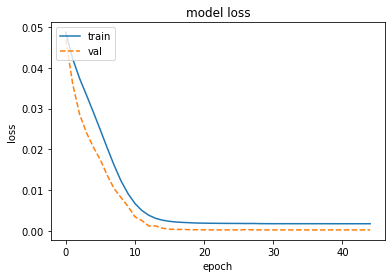

In [13]:
# Вывод графика изменения ошибки
'''plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], linestyle = '--')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()'''

In [14]:
# тест модели

'''model.evaluate(X_test, Y_test, batch_size = FIT_batch_size)'''

54/54 [==============================] - 0s 442us/step - loss: 4.5868e-04


0.00045867630979046226

In [15]:
'''X_test'''

,4,3,2,1
867,0.253278,0.238095,0.229124,0.231194
868,0.238095,0.229124,0.231194,0.240856
869,0.229124,0.231194,0.240856,0.244997
870,0.231194,0.240856,0.244997,0.251208
871,0.240856,0.244997,0.251208,0.249137
...,...,...,...,...
1077,0.193237,0.196687,0.203589,0.204969
1078,0.196687,0.203589,0.204969,0.202208
1079,0.203589,0.204969,0.202208,0.200828
1080,0.204969,0.202208,0.200828,0.204279


In [16]:
'''model.save("NetWork_4_to_1")'''

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: NetWork_4_to_1\assets
